In [2]:
import numpy as np
from tqdm import tqdm
from pynep.calculate import NEP
from pynep.io import load_nep
from active_tools import save_asi, find_inverse
from maxvol import calculate_maxvol
from ase.io import write

nep_file = "nep.txt"
traj = load_nep("train.xyz", ftype="exyz")
calc = NEP(nep_file)

with open(nep_file) as f:
    first_line = f.readline()
    elements = first_line.split(" ")[2:-1]
    print(f"Elements in the NEP potential: {elements}")

B_projections = {e: [] for e in elements}
B_projections_struct_index = {e: [] for e in elements}
print("Calculating B projections...")
for index, atoms in enumerate(tqdm(traj)):
    calc.calculate(atoms, ["B_projection"])
    B_projection = calc.results["B_projection"]
    for b, e in zip(B_projection, atoms.get_chemical_symbols()):
        B_projections[e].append(b)
        B_projections_struct_index[e].append(index)

B_projections_struct_index = {
    e: np.array(i) for e, i in B_projections_struct_index.items()
}


print("Shape of the B matrix:")
for e, b in B_projections.items():
    B_projections[e] = np.vstack(b)
    print(f"{e}: {B_projections[e].shape}")
    assert (
        B_projections[e].shape[0] >= B_projections[e].shape[1]
    ), f"Not enough environments for {e}."

Elements in the NEP potential: ['Na', 'Cl']
Calculating B projections...


100%|██████████| 4725/4725 [00:42<00:00, 111.42it/s]


Shape of the B matrix:
Na: (119999, 960)
Cl: (119999, 960)


In [3]:
print("Performing MaxVol...")
active_set = {}
active_set_struct = []
for e, b in B_projections.items():
    A, selected_index = calculate_maxvol(
        b, B_projections_struct_index[e], batch_size=10000, mode="GPU"
    )
    active_set[e] = A
    active_set_struct.extend(selected_index)
    print("Shape of the active set:")
    print(f"{e}: {active_set[e].shape}")

active_set_struct = list(set(active_set_struct))
active_set_struct.sort()
out_traj = [traj[i] for i in active_set_struct]
for atoms in out_traj:
    atoms.calc = None
write("active_set.xyz", out_traj)

print("Finding inverse...")
active_set_inv = {e: find_inverse(b) for e, b in active_set.items()}

print("Saving active set inverse...")
save_asi(active_set_inv)
print("Done.")

Performing MaxVol...
Maxvol Speed: 229 iters/s
Batch 0: adding 960 envs. 
Maxvol Speed: 253 iters/s
Batch 1: adding 549 envs. 
Maxvol Speed: 242 iters/s
Batch 2: adding 377 envs. 
Maxvol Speed: 254 iters/s
Batch 3: adding 327 envs. 
Maxvol Speed: 241 iters/s
Batch 4: adding 302 envs. 
Maxvol Speed: 231 iters/s
Batch 5: adding 324 envs. 
Maxvol Speed: 231 iters/s
Batch 6: adding 248 envs. 
Maxvol Speed: 242 iters/s
Batch 7: adding 191 envs. 
Maxvol Speed: 200 iters/s
Batch 8: adding 120 envs. 
Maxvol Speed: 121 iters/s
Batch 9: adding 5 envs. 
Maxvol Speed: 137 iters/s
Batch 10: adding 16 envs. 
Maxvol Speed: 188 iters/s
Batch 11: adding 60 envs. 
Refinement round 0: 0 envs out of active set. Max gamma = 0.9997123132548644
Refinement done.
Shape of the active set:
Na: (960, 960)
Maxvol Speed: 307 iters/s
Batch 0: adding 960 envs. 
Maxvol Speed: 288 iters/s
Batch 1: adding 562 envs. 
Maxvol Speed: 277 iters/s
Batch 2: adding 373 envs. 
Maxvol Speed: 280 iters/s
Batch 3: adding 336 envs. 

Calculating gamma...


100%|██████████| 4725/4725 [00:54<00:00, 86.04it/s] 


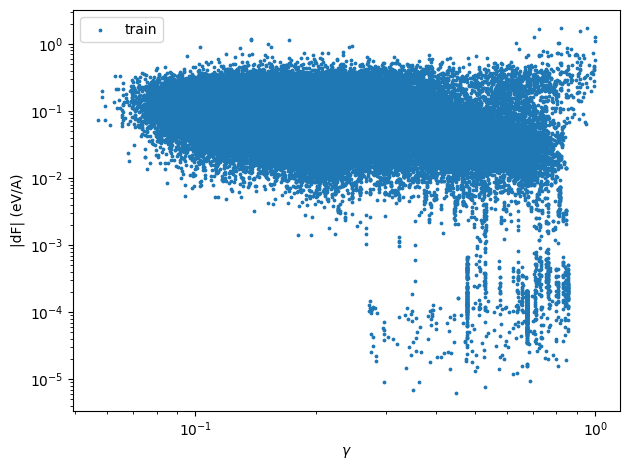

In [4]:
import numpy as np
from tqdm import tqdm
from pynep.calculate import NEP
from ase.io import read
import matplotlib.pyplot as plt
import pandas as pd
from active_tools import load_asi

nep_file = "nep.txt"
calc = NEP(nep_file)

active_set_inverse = load_asi("active_set.asi")


def get_gamma_dF(file):
    traj = read(file, index=":")
    gamma = {k: [] for k in active_set_inverse.keys()}
    dF = {k: [] for k in active_set_inverse.keys()}
    phase = {k: [] for k in active_set_inverse.keys()}

    print("Calculating gamma...")

    for atoms in tqdm(traj):
        dft_F = atoms.arrays["force"]
        calc.calculate(atoms, ["B_projection"])
        B_projection = calc.results["B_projection"]
        nep_F = calc.results["forces"]
        F_error = np.linalg.norm(dft_F - nep_F, axis=1)
        for e in active_set_inverse.keys():
            index = [
                ii for ii in range(len(atoms)) if atoms.get_chemical_symbols()[ii] == e
            ]
            g = B_projection[index] @ active_set_inverse[e]
            g = np.max(np.abs(g), axis=1)
            gamma[e].extend(g)
            dF[e].extend(F_error[index])
            phase[e].extend([atoms.info["config_type"]] * len(index))

    return gamma, dF, phase


gamma, dF, phase = get_gamma_dF("train.xyz")
plt.scatter(gamma["Na"], dF["Na"], s=3, label="train")


plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.xlabel(r"$\gamma$")
plt.ylabel("|dF| (eV/A)")
plt.tight_layout()
plt.legend()
plt.savefig("gamma-dF.png", transparent=False)